In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from bgflow.utils import remove_mean, as_numpy
from bgflow import MeanFreeNormalDistribution, OpenMMBridge, OpenMMEnergy
from bgflow.bg import sampling_efficiency
from tbg.utils import create_adjacency_list, find_chirality_centers, compute_chirality_sign, check_symmetry_change
import tqdm
import os
import mdtraj as md
import networkx as nx
from networkx.algorithms import isomorphism
import nglview as nv
import scipy
import openmm
import deeptime as dt
import signal


In [3]:
data_path = "/srv/data/yaoyic/timewarp-data/2AA-1-huge"
#data_path = "data/2AA-1-huge"

atom_dict = {"H": 0, "C":1, "N":2, "O":3, "S":4}
scaling = 30
n_dimensions = 3
data = {}
priors = {}
topologies = {}
atom_types_dict = {}
validation_peptides = ['KS', 'KG', 'AT', 'GN', 'LW', 'KQ', 'NY', 'IM', 'TD', 'HT', 'NF','RL', 'ET', 'AC', 'GP', 'RV']
for peptide in tqdm.tqdm(validation_peptides):   
    npz = np.load(data_path+f"/test/{peptide}-traj-arrays.npz")
    n_atoms = npz['positions'].shape[1]
    data[peptide] = remove_mean(npz['positions'][npz['step']%10000==0].reshape(-1, n_atoms*n_dimensions)[:190000], n_atoms, n_dimensions)*scaling
    topologies[peptide] = md.load_topology(data_path+f"/test/{peptide}-traj-state0.pdb")
    atom_types = []
    for atom_name in topologies[peptide].atoms:
        atom_types.append(atom_name.name[0])
    atom_types_dict[peptide] = np.array([atom_dict[atom_type] for atom_type in atom_types])


    priors[peptide] = MeanFreeNormalDistribution(n_atoms*n_dimensions, n_atoms, two_event_dims=False)#.cuda()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:10<00:00,  4.40s/it]


In [4]:
#test
peptide = 'KS'
#peptide = 'KG'
#peptide = 'AT'
#peptide = 'GN'
#peptide = 'LW'
#peptide = 'KQ'
#peptide = 'NY'
#peptide = 'IM'
#peptide = 'TD'
#peptide = 'HT'
#peptide = 'NF'
#peptide = 'RL'
#peptide = 'ET'
#peptide = 'AC'
#peptide = 'RV'
#peptide = 'GP'


dim =len(atom_types_dict[peptide])*n_dimensions


In [5]:
atom_dict = {"C": 0, "H":1, "N":2, "O":3, "S":4}
#["C", "H", "N", "O", "S"]
atom_types = []
for atom_name in topologies[peptide].atoms:
    atom_types.append(atom_name.name[0])
atom_types = torch.from_numpy(np.array([atom_dict[atom_type] for atom_type in atom_types]))
backbone_idxs = topologies[peptide].select("backbone")

adj_list = torch.from_numpy(np.array([(b.atom1.index, b.atom2.index) for b in topologies[peptide].bonds], dtype=np.int32))

In [6]:
import networkx.algorithms.isomorphism as iso
import networkx as nx
import scipy

def align_topology(sample, reference, scaling=scaling):
    sample = sample.reshape(-1, 3)
    all_dists = scipy.spatial.distance.cdist(sample, sample)
    adj_list_computed = create_adjacency_list(all_dists/scaling, atom_types)
    G_reference = nx.Graph(reference)
    G_sample = nx.Graph(adj_list_computed)
    # not same number of nodes
    if len(G_sample.nodes) != len(G_reference.nodes):
        return sample, False
    for i, atom_type in enumerate(atom_types):
        G_reference.nodes[i]['type']=atom_type
        G_sample.nodes[i]['type']=atom_type
        
    nm = iso.categorical_node_match("type", -1)
    GM = isomorphism.GraphMatcher(G_reference, G_sample, node_match=nm)
    is_isomorphic = GM.is_isomorphic()
    # True
    GM.mapping
    initial_idx = list(GM.mapping.keys())
    final_idx = list(GM.mapping.values())
    sample[initial_idx] = sample[final_idx]
    return sample, is_isomorphic

In [31]:
loaded_samples = np.load(f"/result_data/tbg_full_{peptide}.npz")
#loaded_samples = np.load(f"/result_data/tbg_backbone_{peptide}.npz")
#loaded_samples = np.load(f"/result_data/tbg_{peptide}.npz")

latent_np = loaded_samples["latent_np"]
samples_np = loaded_samples["samples_np"]
dlogp_np=loaded_samples["dlogp_np"]


In [32]:
traj_samples = md.Trajectory(samples_np.reshape(-1, dim//3, 3)/scaling, topology=topologies[peptide])
nv.show_mdtraj(traj_samples)

NGLWidget(max_frame=29499)

In [33]:

def handler(signum, frame):
    raise TimeoutError("Function call took too long")

aligned_samples = []
aligned_idxs = []
#for i, sample in enumerate(samples_np[(energies_np.flatten() < -52800)].reshape(-1,dim//3, 3)):
for i, sample in tqdm.tqdm(enumerate(samples_np.reshape(-1,dim//3, 3))):   
        # Set a timer for 5 seconds
    signal.signal(signal.SIGALRM, handler)
    signal.alarm(5)  # Timeout set to 5 seconds

    try:
        # Call your function here
        aligned_sample, is_isomorphic = align_topology(sample, as_numpy(adj_list).tolist())
        if is_isomorphic:
            aligned_samples.append(aligned_sample)
            aligned_idxs.append(i)
    except TimeoutError: 
        print("Skipping iteration, function call took too long")
        continue  # Skip to the next iteration
    finally:
        signal.alarm(0)

aligned_samples = np.array(aligned_samples)
aligned_samples.shape


29500it [03:40, 133.76it/s]


(29451, 36, 3)

In [34]:
print(f"Correct configuration rate {len(aligned_samples)/len(samples_np)}")

Correct configuration rate 0.9983389830508475


In [35]:
import nglview as nv

traj_samples_data = md.Trajectory(data[peptide].reshape(-1, dim//3, 3)/scaling, topology=topologies[peptide])

view = nv.show_mdtraj(traj_samples_data)

view

NGLWidget(max_frame=189999)

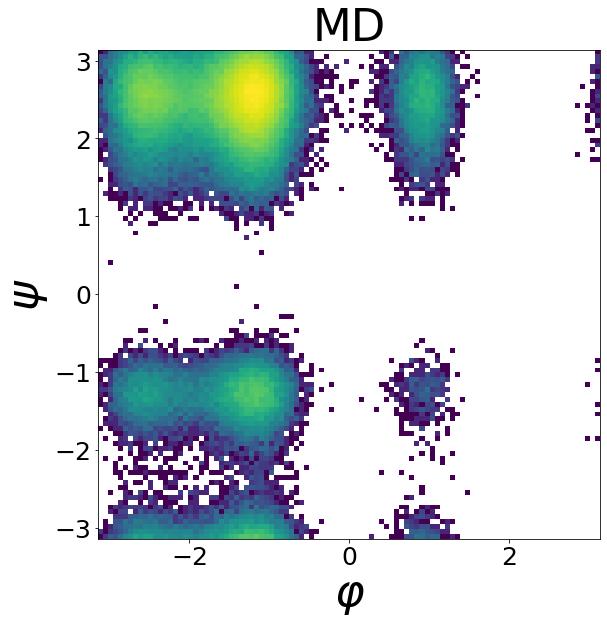

In [36]:
fig, ax = plt.subplots(figsize=(9, 9))
plot_range = [-np.pi, np.pi]
phis_data = md.compute_phi(traj_samples_data)[1].flatten()
psis_data = md.compute_psi(traj_samples_data)[1].flatten()
h, x_bins, y_bins, im = ax.hist2d(phis_data, psis_data, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_xlabel(r"$\varphi$", fontsize=45)
ax.set_title("MD", fontsize=45)
ax.set_ylabel(r"$\psi$", fontsize=45)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)



In [37]:
traj_samples_alinged = md.Trajectory(aligned_samples/scaling, topology=topologies[peptide])

nv.show_mdtraj(traj_samples_alinged)

NGLWidget(max_frame=29450)

In [38]:
model_samples = torch.from_numpy(traj_samples_alinged.xyz)
chirality_centers = find_chirality_centers(adj_list, atom_types)
reference_signs = compute_chirality_sign(torch.from_numpy(data[peptide].reshape(-1, dim//3, 3))[[1]], chirality_centers)
symmetry_change = check_symmetry_change(model_samples, chirality_centers, reference_signs)
model_samples[symmetry_change] *=-1
symmetry_change = check_symmetry_change(model_samples, chirality_centers, reference_signs)


In [39]:
print(f"Correct symmetry rate {(~symmetry_change).sum()/len(model_samples)}")


Correct symmetry rate 0.9783029556274414


In [40]:
print(f"Correct rate {(~symmetry_change).sum()/len(samples_np)}")


Correct rate 0.9766779541969299


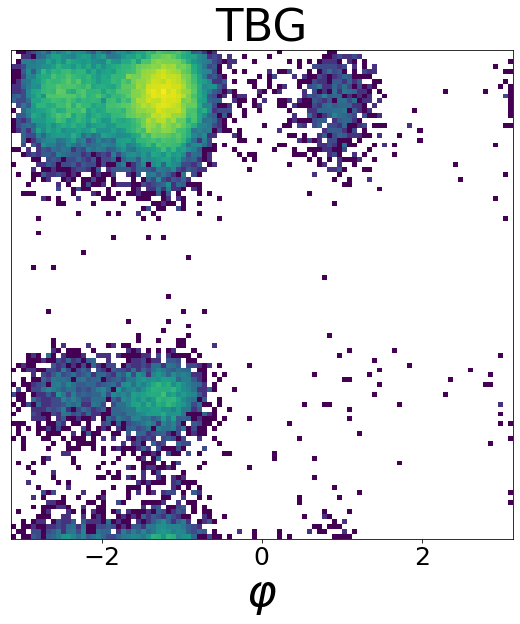

In [41]:
traj_samples = md.Trajectory(as_numpy(model_samples)[~symmetry_change], topology=topologies[peptide])


fig, ax = plt.subplots(figsize=(9, 9))
plot_range = [-np.pi, np.pi]
phis = md.compute_phi(traj_samples)[1].flatten()
psis = md.compute_psi(traj_samples)[1].flatten()
h, x_bins, y_bins, im = ax.hist2d(phis, psis, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_xlabel(r"$\varphi$", fontsize=45)
ax.set_title("TBG", fontsize=45)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
ax.set_yticks([]);


In [42]:
pdb_path = data_path+f"/test/{peptide}-traj-state0.pdb"

pdb = openmm.app.PDBFile(pdb_path)
forcefield = openmm.app.ForceField("amber14-all.xml", "implicit/obc1.xml")

system = forcefield.createSystem(pdb.topology, nonbondedMethod=openmm.app.CutoffNonPeriodic,
        nonbondedCutoff=2.0*openmm.unit.nanometer, constraints=None)
integrator = openmm.LangevinMiddleIntegrator(310*openmm.unit.kelvin, 0.3/openmm.unit.picosecond, 0.5*openmm.unit.femtosecond)
openmm_energy = OpenMMEnergy(bridge=OpenMMBridge(system, integrator, platform_name="CUDA"))


In [43]:
classical_model_energies = as_numpy(openmm_energy.energy(model_samples.reshape(-1, dim)[~symmetry_change]))
classical_target_energies = as_numpy(openmm_energy.energy(torch.from_numpy(data[peptide])[::10].reshape(-1, dim)/scaling))

In [44]:
len(aligned_idxs)

29451

In [45]:
idxs = np.array(aligned_idxs)[~symmetry_change]
log_w_np = -classical_model_energies + as_numpy(priors[peptide].energy(torch.from_numpy(latent_np[idxs]))) + dlogp_np.reshape(-1,1)[idxs]

In [46]:
ess = sampling_efficiency(torch.from_numpy(log_w_np)).item()
ess

0.060117699555166125

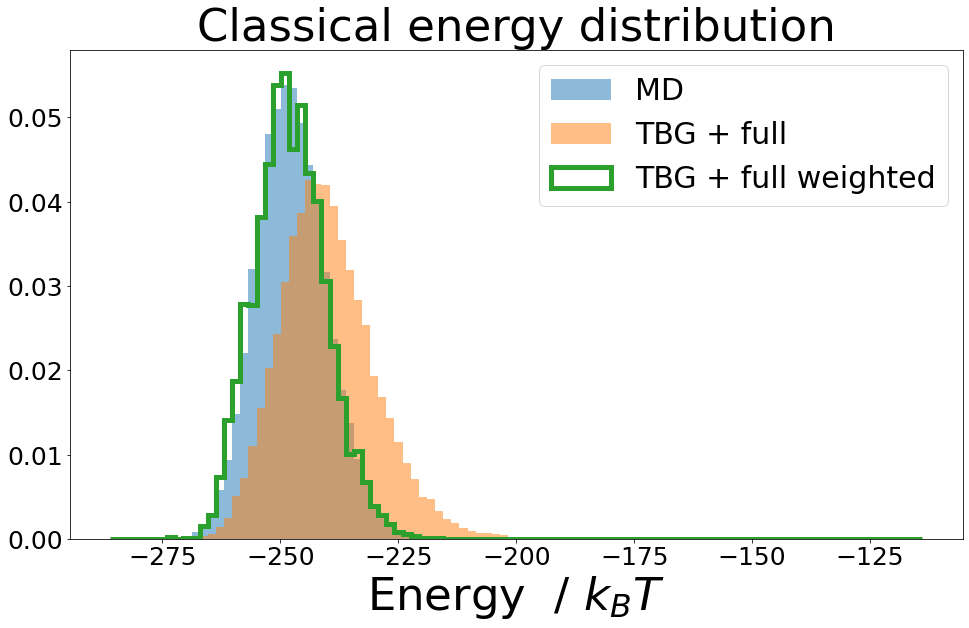

In [47]:
plt.figure(figsize=(16,9))
range_limits = (classical_target_energies.min()-10,classical_target_energies.max()+100)
plt.hist(classical_target_energies, bins=100, alpha=0.5, range=range_limits,density=True, label="MD");
plt.hist(classical_model_energies, bins=100,alpha=0.5, range=range_limits,density=True, label="TBG + full");
plt.hist(classical_model_energies, bins=100, range=range_limits,density=True, label="TBG + full weighted", weights=np.exp(log_w_np), histtype='step', linewidth=5);

plt.legend(fontsize=30)
plt.xlabel("Energy  / $k_B T$", fontsize=45)  
plt.yticks(fontsize=25);
plt.xticks(fontsize=25);


plt.title(f"Classical energy distribution", fontsize=45);

(-0.5, 13.0)

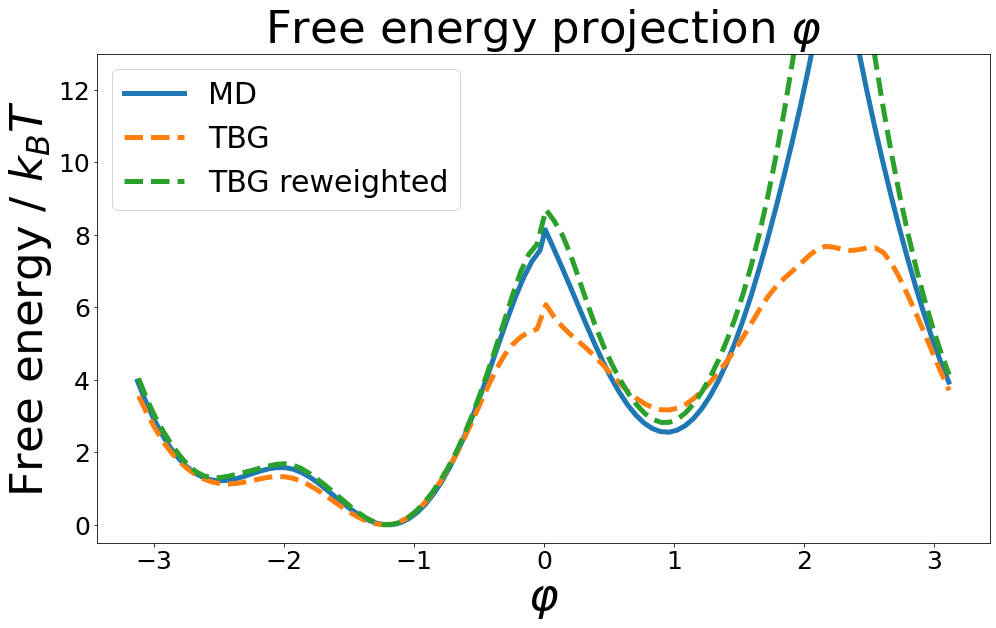

In [48]:
def plot_fes(
    samples: np.ndarray,
    bw_method:  None,
    weights: None,
    get_DeltaF: bool = True,
    kBT: float = 1.0,
):
    from scipy.stats import gaussian_kde
    bw_method = 0.18
    grid = np.linspace(samples.min(), samples.max(), 100)
    fes = -kBT * gaussian_kde(samples, bw_method, weights).logpdf(grid)
    fes -= fes.min()

    return grid, fes
phi_right = phis_data.copy()
phi_left = phis_data.copy()
phi_right[phis_data<0] += 2*np.pi
phi_left[phis_data>np.pi/2] -= 2*np.pi       

#plot_fes(phi,bw_method=None, weights=np.exp(log_w_np),get_DeltaF=False)
grid_left, fes_left = plot_fes(phi_left,bw_method=None, weights=None, get_DeltaF=False)
grid_right, fes_right = plot_fes(phi_right,bw_method=None, weights=None, get_DeltaF=False)
middle = 0#1.1
idx_left = (grid_left>=-np.pi)&(grid_left<middle)
grid_left_data  = grid_left[idx_left]
fes_left_data  = fes_left[idx_left]
idx_right = (grid_right<=np.pi)&(grid_right>middle)
grid_right_data  = grid_right[idx_right]
fes_right_data  = fes_right[idx_right]


phi_right = phis.copy()
phi_left = phis.copy()
phi_right[phis<0] += 2*np.pi
phi_left[phis>np.pi/2] -= 2*np.pi       

#plot_fes(phi,bw_method=None, weights=np.exp(log_w_np),get_DeltaF=False)
grid_left, fes_left = plot_fes(phi_left,bw_method=None, weights=None, get_DeltaF=False)
grid_right, fes_right = plot_fes(phi_right,bw_method=None, weights=None, get_DeltaF=False)
middle = 0#1.1
idx_left = (grid_left>=-np.pi)&(grid_left<middle)
grid_left = grid_left[idx_left]
fes_left = fes_left[idx_left]
idx_right = (grid_right<=np.pi)&(grid_right>middle)
grid_right = grid_right[idx_right]
fes_right = fes_right[idx_right]

plt.figure(figsize=(16,9))
plt.plot(np.hstack([grid_left_data, grid_right_data]), np.hstack([fes_left_data, fes_right_data]), linewidth=5, label="MD")
plt.plot(np.hstack([grid_left, grid_right]), np.hstack([fes_left, fes_right]), linewidth=5, linestyle="--", label="TBG")

phi_right = phis.copy()
phi_left = phis.copy()
phi_right[phis<0] += 2*np.pi
phi_left[phis>np.pi/2] -= 2*np.pi       

grid_left, fes_left = plot_fes(phi_left,bw_method=None, weights=np.exp(log_w_np).flatten(), get_DeltaF=False)
grid_right, fes_right = plot_fes(phi_right,bw_method=None, weights=np.exp(log_w_np).flatten(), get_DeltaF=False)
middle = 0#1.1
idx_left = (grid_left>=-np.pi)&(grid_left<middle)
grid_left = grid_left[idx_left]
fes_left = fes_left[idx_left]
idx_right = (grid_right<=np.pi)&(grid_right>middle)
grid_right = grid_right[idx_right]
fes_right = fes_right[idx_right]
plt.plot(np.hstack([grid_left, grid_right]), np.hstack([fes_left, fes_right]), linewidth=5, linestyle="--", label="TBG reweighted")

plt.legend(fontsize=25)
plt.xlabel("Phi", fontsize=45)  
plt.ylabel("Free energy / kbT", fontsize=45)  

phi_right = phis.copy()
phi_left = phis.copy()
phi_right[phis<0] += 2*np.pi
phi_left[phis>np.pi/2] -= 2*np.pi       

grid_left, fes_left = plot_fes(phi_left,bw_method=None, weights=np.exp(log_w_np).flatten(), get_DeltaF=False)
grid_right, fes_right = plot_fes(phi_right,bw_method=None, weights=np.exp(log_w_np).flatten(), get_DeltaF=False)
middle = 0#1.1
idx_left = (grid_left>=-np.pi)&(grid_left<middle)
grid_left = grid_left[idx_left]
fes_left = fes_left[idx_left]
idx_right = (grid_right<=np.pi)&(grid_right>middle)
grid_right = grid_right[idx_right]
fes_right = fes_right[idx_right]
#plt.plot(np.hstack([grid_left, grid_right]), np.hstack([fes_left, fes_right]), linewidth=5, linestyle="--", label="TBG cutoff weighted")
plt.legend(fontsize=30);
plt.title(r"Free energy projection $\varphi$", fontsize=45)
plt.xlabel(r"$\varphi$", fontsize=45)
plt.ylabel("Free energy / $k_B T$", fontsize=45)
plt.xticks(fontsize=25);
plt.yticks(fontsize=25);
plt.ylim(-0.5,13)


# TICA

In [49]:
SELECTION = "symbol == C or symbol == N or symbol == S"

def distances(xyz):
    distance_matrix_ca = np.linalg.norm(
        xyz[:, None, :, :] - xyz[:, :, None, :],
        axis=-1
    )
    n_ca = distance_matrix_ca.shape[-1]
    m, n = np.triu_indices(n_ca, k=1)
    distances_ca = distance_matrix_ca[:, m, n]
    return distances_ca

def wrap(array):
    return (np.sin(array), np.cos(array))

def tica_features(
    trajectory,
    use_dihedrals=True,
    use_distances=True,
    selection=SELECTION
):
    trajectory = trajectory.atom_slice(trajectory.top.select(selection))
    n_atoms = trajectory.xyz.shape[1]
    if use_dihedrals:
        _, phi = md.compute_phi(
            trajectory
        )
        _, psi = md.compute_psi(
            trajectory
        )
        _, omega= md.compute_omega(
            trajectory
        )
        dihedrals = np.concatenate([*wrap(phi), *wrap(psi), *wrap(omega)], axis=-1)
    if use_distances:
        ca_distances = distances(trajectory.xyz)
    if use_distances and use_dihedrals:
        return np.concatenate([ca_distances, dihedrals], axis=-1)
    elif use_distances:
        return ca_distances
    elif use_dihedrals:
        return ca_dihedrals
    else:
        return []
    
from matplotlib.colors import LogNorm

def plot_tic01(ax, tics, name, tics_lims, cmap='viridis'):
    _ = ax.hist2d(tics[:,0], tics[:,1], bins=100, norm=LogNorm(), cmap=cmap,rasterized=True)
    ax.set_xlabel("TIC0", fontsize=45)
    ax.set_ylabel("TIC1", fontsize=45)
    ax.set_ylim(tics_lims[:,1].min(),tics_lims[:,1].max())
    ax.set_xlim(tics_lims[:,0].min(),tics_lims[:,0].max())
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(f"{name}", fontsize=45)
    return ax
def run_tica(trajectory, lagtime=500, dim=40):
    ca_features = tica_features(trajectory)
    tica = dt.decomposition.TICA(dim=dim, lagtime=lagtime)
    koopman_estimator = dt.covariance.KoopmanWeightingEstimator(lagtime=lagtime)
    reweighting_model = koopman_estimator.fit(ca_features).fetch_model()
    tica_model = tica.fit(ca_features, reweighting_model).fetch_model()
    return tica_model

In [50]:
tica_model = run_tica(traj_samples_data, lagtime=100)
features = tica_features(traj_samples_data)
tics = tica_model.transform(features)
feat_model = tica_features(traj_samples)
tics_model = tica_model.transform(feat_model)

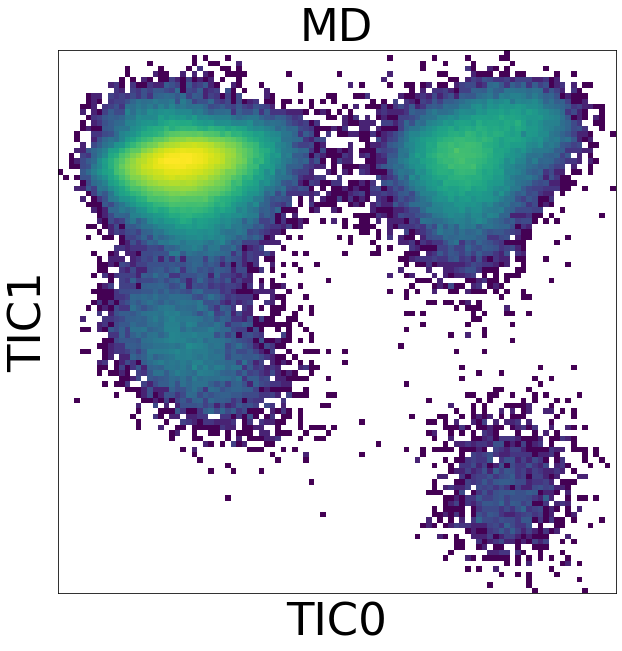

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plot_tic01(ax, tics, f"MD", tics_lims=tics)



Text(0, 0.5, '')

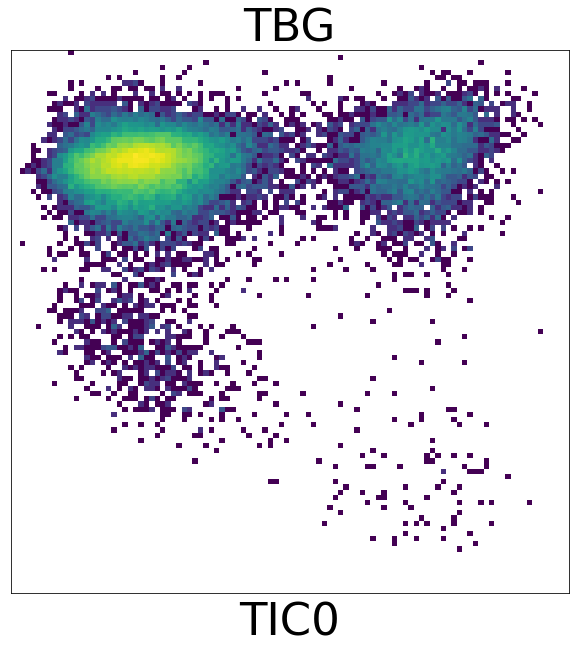

In [52]:
fig, ax = plt.subplots(figsize=(10,10))
plot_tic01(ax, tics_model, f"TBG", tics_lims=tics)
ax.set_ylabel("")

